# Классификация дефектов кожи

В данной работе выполнена классификация с использованием CNN в Tensorflow.

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [2]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay as ExpDecay

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,UpSampling2D, GlobalAveragePooling2D,Conv2DTranspose, BatchNormalization,GlobalMaxPool2D, Convolution2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [3]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.0


In [4]:
print(tf.__version__)

2.4.0


In [5]:
from tensorflow.keras.applications import InceptionV3

In [6]:
keras.applications.EfficientNetB4()

78872576/78864416 [==============================] - 1s 0us/step


In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpmodel.summary()y        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpmodel.summary()y        : 1.19.5
Tensorflow   : 2.4.0


# Задаем константы

In [8]:
train_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

In [9]:
RANDOM_SEED = 42
IMAGE_SIZE         = (512, 512)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 512 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 6
VAL_BATCH_SIZE = 8
VAL_SPLIT          = 0.2 # сколько данных выделяем на тест = 15%
EPOCHS = 12
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

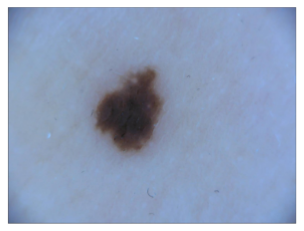

In [10]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "nevus/ISIC_0000041.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")  "ISIC_0000398.jpg"
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)
x

In [24]:
# C помощью glob определяем сколько разных папок-классов с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  9


## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [14]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [15]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [16]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


Found 118 images belonging to 9 classes.


In [ ]:
train_generator

## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [11]:
!pip install albumentations

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-oxrj27ka
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-oxrj27ka
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=5114e7de6f2c07f39392711245305e9757fd75f4a126c3c9ae0e70916df00f35
  Stored in directory: /tmp/pip-ephem-wheel-cache-zepa3w_9/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [13]:
#Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [14]:
# попробовать этот вариант

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=90),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
   # albumentations.HueSaturationValue(p=0.5),
    albumentations.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.00, always_apply=False, p=0.5),
    albumentations.RandomContrast(limit=0.1, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [ ]:
# Либо этот вариант. 


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [15]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [16]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 118 images belonging to 9 classes.


Пример картинок из train_generator


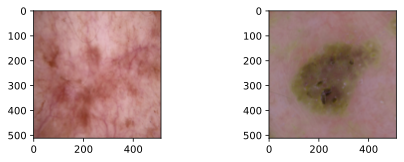

In [17]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,2):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [18]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

(6, 512, 512, 3) (6, 9)


# Посмотрим распределение данных по классам.

In [134]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(train_path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

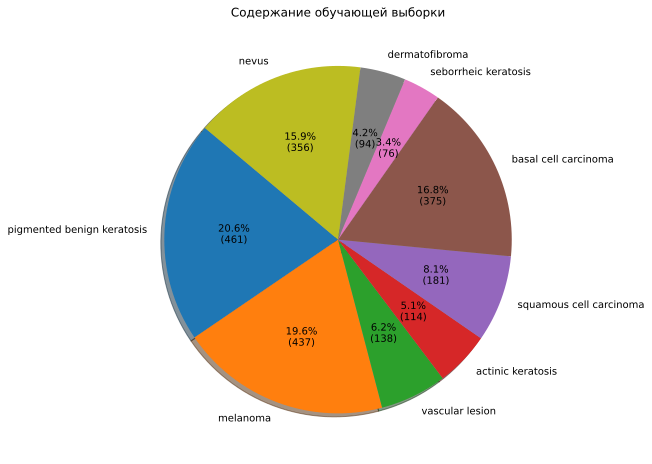

In [135]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

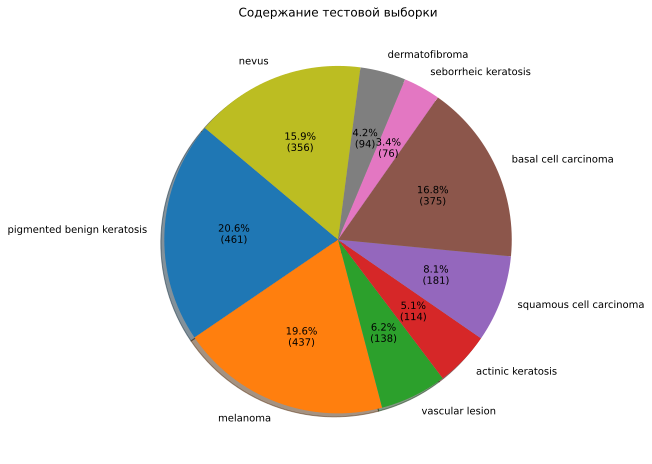

In [136]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [137]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)
    

    values = list(classes_val.values())
    labels = list(classes_val.keys())

    index = [n for n in range(numberOfClass)]
    plt.figure(figsize=(10, 5))
    #hist, bins = np.histogram(values, bins=9)
    plt.bar(values, (values), width=10)
 #   plt.bar(range(len(values)),[values[k] for k in values], width=20)
    
    #plt.xlabel('Градация болезней', fontsize=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

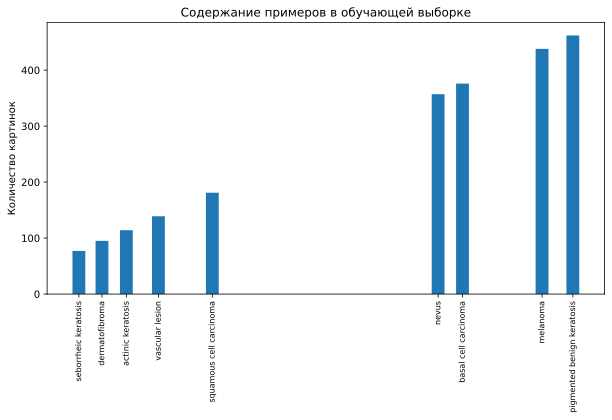

In [138]:
plot_dataset_description_bar(os.path.join(train_path), 'Содержание примеров в обучающей выборке')

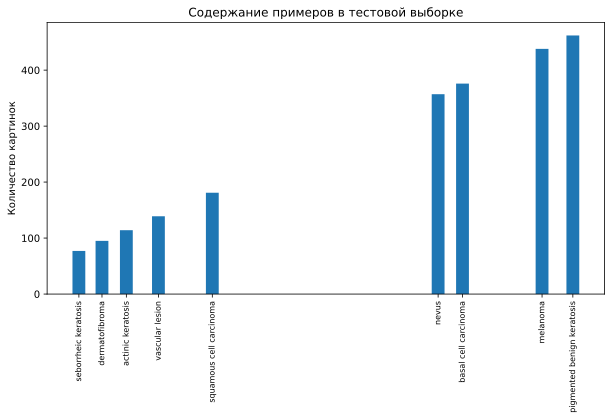

In [139]:
plot_dataset_description_bar(os.path.join(test_path), 'Содержание примеров в тестовой выборке')

In [140]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)
print(len(train_generator))

(6, 512, 512, 3) (6, 9)
300


# Построение и обучение модели.

In [ ]:
#model = keras.models.load_model('/kaggle/input/inputmod/best_model_step1.hdf5')

## Вынесем функции для раздела построения и обучения модели.

In [19]:
def info_layers():
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    print("Number of layers in the base model: ", len(base_model.layers))
    print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    print("Layers in the model:")
    for layer in model.layers:
        print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    


In [20]:
# CallBack для сохранения модели, ее весов и лучшей модели, изменения LR в случае отсутствия прогресса обучения, и остновка обучения

weightpath = "best_model.hdf5"
checkpoint = ModelCheckpoint(weightpath , monitor = 'val_accuracy' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True
reducer = ReduceLROnPlateau(monitor='loss', patience= 3,factor=0.2, min_lr=0.00000001,  verbose = 1, cooldown=2, mode='auto',min_delta=0.0000001) #min_delta=0.000000001
early_stop= EarlyStopping(monitor='loss',patience= 10, mode='min')  #min_delta=0.000000001


In [21]:
callbacks_list = [checkpoint, reducer, early_stop] 

## Шаг1  Сформирмируем сверточную нейросеть CNN

In [22]:
# В процессе обучения проводились опыты с разными моделями, в качестве base_model необходимо выбрать  Xception, 
# как показавшую лучшие результаты

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

71688192/71686520 [==============================] - 1s 0us/step


In [44]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [45]:
# Установим все слои base_model в неактивное состояние

base_model.trainable = False

In [48]:
model=Sequential()
model.add(base_model)

#model.add(GlobalAveragePooling2D(),)
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
#model.add(BatchNormalization())
print('ок')
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

ок


In [ ]:
# лучшая модель 

model=Sequential()
model.add(base_model)

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
print('ок')
model.add(Flatten())
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

In [26]:
train_generator.samples

1795

In [27]:
test_generator.samples

444

In [23]:
model = Sequential()
model.add(Xception(include_top = False, weights = "imagenet",
                        input_shape=(IMG_SIZE,IMG_SIZE, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(numberOfClass, activation = "softmax"))



In [49]:
# Посмотрим информацию о количестве слоев модели и модели Imagenet

info_layers()

Number of layers in the model: 17
Number of trainable_variables layers in the model: 14
Number of layers in the base model:  132
Number of variables layers in the base model:  0
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f26885c08d0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f268826f350> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26a9586690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883da2d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f26885554d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f268806ed90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883de5d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2688075fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26885a5f10> True
<tensorflow.python.keras.layers.pooling.MaxP

In [50]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 88

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-fine_tune_at]:
  layer.trainable =  False

In [51]:
info_layers()

Number of layers in the model: 17
Number of trainable_variables layers in the model: 119
Number of layers in the base model:  132
Number of variables layers in the base model:  105
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f26885c08d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f268826f350> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26a9586690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883da2d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f26885554d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f268806ed90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883de5d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2688075fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26885a5f10> True
<tensorflow.python.keras.layers.pooling.Ma

In [53]:
# Посмотрим структуру модели

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 2048)      8192      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        589856    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)         

In [36]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 4.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0
    Uninstalling pip-21.0:
      Successfully uninstalled pip-21.0


In [37]:
!pip install pydot

In [141]:
# Посмотрим на схему модели.

#from tensorflow.keras import utils

utils.plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [55]:
# Компилируем модель

LR=0.0008
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 50, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/52
300/300 [==============================] - 158s 501ms/step - loss: 2.0685 - accuracy: 0.2257 - val_loss: 3.6359 - val_accuracy: 0.2162

Epoch 00001: val_accuracy improved from -inf to 0.21622, saving model to best_model.hdf5
Epoch 2/52
300/300 [==============================] - 144s 481ms/step - loss: 1.8202 - accuracy: 0.3654 - val_loss: 2.3613 - val_accuracy: 0.3198

Epoch 00002: val_accuracy improved from 0.21622 to 0.31982, saving model to best_model.hdf5
Epoch 3/52
300/300 [==============================] - 145s 482ms/step - loss: 1.6743 - accuracy: 0.4059 - val_loss: 3.7312 - val_accuracy: 0.3086

Epoch 00003: val_accuracy did not improve from 0.31982
Epoch 4/52
300/300 [==============================] - 144s 481ms/step - loss: 1.5124 - accuracy: 0.4823 - val_loss: 2.5040 - val_accuracy: 0.4009

Epoch 00004: val_accuracy improved from 0.31982 to 0.40090, saving model to best_model.hdf5
Epoch 5/52
300/300 [==============================] - 145s 483ms/step - loss: 1.4580

300/300 [==============================] - 145s 484ms/step - loss: 0.6356 - accuracy: 0.7570 - val_loss: 1.0810 - val_accuracy: 0.6577

Epoch 00040: val_accuracy did not improve from 0.69820
Epoch 41/52
300/300 [==============================] - 145s 483ms/step - loss: 0.5585 - accuracy: 0.7922 - val_loss: 1.4100 - val_accuracy: 0.6441

Epoch 00041: val_accuracy did not improve from 0.69820
Epoch 42/52
300/300 [==============================] - 145s 484ms/step - loss: 0.5693 - accuracy: 0.7959 - val_loss: 1.5743 - val_accuracy: 0.6171

Epoch 00042: val_accuracy did not improve from 0.69820
Epoch 43/52
300/300 [==============================] - 145s 483ms/step - loss: 0.5736 - accuracy: 0.7975 - val_loss: 2.4862 - val_accuracy: 0.5045

Epoch 00043: val_accuracy did not improve from 0.69820
Epoch 44/52
300/300 [==============================] - 144s 481ms/step - loss: 0.6152 - accuracy: 0.7731 - val_loss: 1.7794 - val_accuracy: 0.5586

Epoch 00044: val_accuracy did not improve from 0.698

In [58]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_111.hdf5')
model.load_weights('best_model.hdf5')

In [60]:
#model = keras.models.load_model('model_last_111.hdf5')

In [142]:
graph(history)

In [ ]:
шаг2

In [70]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 22

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [71]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 17
Number of trainable_variables layers in the model: 143
Number of layers in the base model:  132
Number of variables layers in the base model:  129
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f26885c08d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f268826f350> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26a9586690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883da2d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f26885554d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f268806ed90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883de5d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2688075fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26885a5f10> True
<tensorflow.python.keras.layers.pooling.Ma

In [72]:
# Посмотрим структуру модели

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 2048)      8192      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        589856    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)         

In [73]:
# Компилируем модель

LR=0.000002
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))


In [74]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 47, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/47
300/300 [==============================] - 100s 317ms/step - loss: 1.4590 - accuracy: 0.5500 - val_loss: 1.4524 - val_accuracy: 0.5180

Epoch 00001: val_accuracy did not improve from 0.54279
Epoch 2/47
300/300 [==============================] - 94s 314ms/step - loss: 1.1817 - accuracy: 0.5896 - val_loss: 1.2294 - val_accuracy: 0.5743

Epoch 00002: val_accuracy improved from 0.54279 to 0.57432, saving model to best_model.hdf5
Epoch 3/47
300/300 [==============================] - 95s 317ms/step - loss: 1.1788 - accuracy: 0.5892 - val_loss: 1.1636 - val_accuracy: 0.5788

Epoch 00003: val_accuracy improved from 0.57432 to 0.57883, saving model to best_model.hdf5
Epoch 4/47
300/300 [==============================] - 94s 314ms/step - loss: 1.0341 - accuracy: 0.6500 - val_loss: 1.2032 - val_accuracy: 0.5631

Epoch 00004: val_accuracy did not improve from 0.57883
Epoch 5/47
300/300 [==============================] - 95s 317ms/step - loss: 1.0701 - accuracy: 0.6389 - val_loss: 1.2773

300/300 [==============================] - 92s 306ms/step - loss: 0.5918 - accuracy: 0.7646 - val_loss: 1.3078 - val_accuracy: 0.6239

Epoch 00040: val_accuracy did not improve from 0.63964
Epoch 41/47
300/300 [==============================] - 92s 308ms/step - loss: 0.6273 - accuracy: 0.7715 - val_loss: 1.2798 - val_accuracy: 0.6419

Epoch 00041: val_accuracy improved from 0.63964 to 0.64189, saving model to best_model.hdf5
Epoch 42/47
300/300 [==============================] - 92s 306ms/step - loss: 0.6229 - accuracy: 0.7617 - val_loss: 1.3509 - val_accuracy: 0.6261

Epoch 00042: val_accuracy did not improve from 0.64189
Epoch 43/47
300/300 [==============================] - 92s 306ms/step - loss: 0.6170 - accuracy: 0.7726 - val_loss: 1.3233 - val_accuracy: 0.6261

Epoch 00043: val_accuracy did not improve from 0.64189

Epoch 00043: ReduceLROnPlateau reducing learning rate to 2.8000000384054148e-06.
Epoch 44/47
300/300 [==============================] - 92s 305ms/step - loss: 0.5680 

In [75]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_112.hdf5')
model.load_weights('best_model.hdf5')

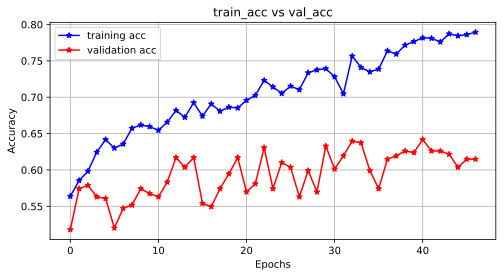

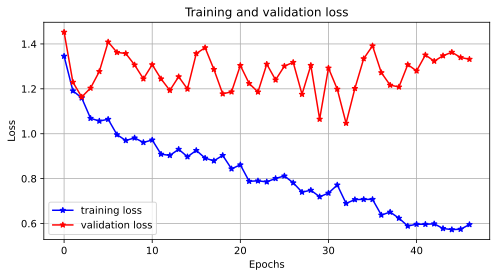

In [76]:
graph(history)

In [ ]:
# Шаг3

In [77]:
base_model.trainable = False

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 309

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [78]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 17
Number of trainable_variables layers in the model: 14
Number of layers in the base model:  132
Number of variables layers in the base model:  0
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f26885c08d0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f268826f350> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26a9586690> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883da2d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f26885554d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f268806ed90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f26883de5d0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2688075fd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f26885a5f10> True
<tensorflow.python.keras.layers.pooling.MaxP

In [79]:
# Посмотрим структуру модели

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 2048)      8192      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 32)        589856    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)         

In [88]:
# Компилируем модель

LR=0.0000002
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

In [89]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 20, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/20
300/300 [==============================] - 86s 274ms/step - loss: 0.5944 - accuracy: 0.7900 - val_loss: 1.3180 - val_accuracy: 0.6441

Epoch 00001: val_accuracy did not improve from 0.65991
Epoch 2/20
300/300 [==============================] - 81s 270ms/step - loss: 0.5699 - accuracy: 0.7974 - val_loss: 1.3746 - val_accuracy: 0.6577

Epoch 00002: val_accuracy did not improve from 0.65991
Epoch 3/20
300/300 [==============================] - 82s 274ms/step - loss: 0.5709 - accuracy: 0.7942 - val_loss: 1.3922 - val_accuracy: 0.6509

Epoch 00003: val_accuracy did not improve from 0.65991
Epoch 4/20
300/300 [==============================] - 82s 272ms/step - loss: 0.6026 - accuracy: 0.7926 - val_loss: 1.4031 - val_accuracy: 0.6532

Epoch 00004: val_accuracy did not improve from 0.65991
Epoch 5/20
300/300 [==============================] - 82s 275ms/step - loss: 0.6156 - accuracy: 0.7736 - val_loss: 1.4030 - val_accuracy: 0.6554

Epoch 00005: val_accuracy did not improve from 0.6

In [94]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_115.hdf5')
model.load_weights('best_model.hdf5')

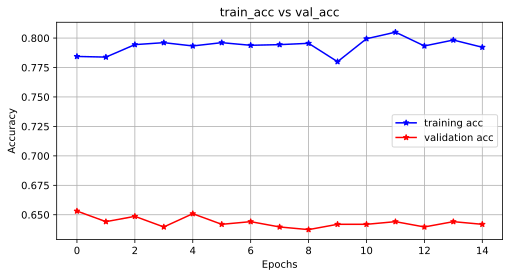

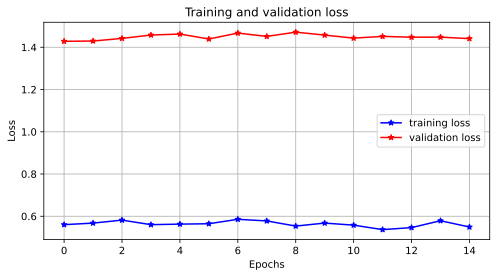

In [86]:
graph(history)

In [ ]:
# Шаг4

In [87]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 98

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [ ]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

In [ ]:
# Посмотрим структуру модели

model.summary()

In [ ]:
# Компилируем модель

LR=0.00007
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 25, #EPOCHS,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
graph(history)

# Результаты

In [130]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


74/74 [==============================] - 14s 182ms/step - loss: 1.3926 - accuracy: 0.6509
Accuracy: 65.09%


## Confugn matrix по тестовым данным

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # функция рисования confusion_matrix

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [125]:
%%time
Y_pred = model.predict_generator(test_generator,verbose=1)  # test_val_generator
Y_pred

74/74 [==============================] - 14s 184ms/step
CPU times: user 17.9 s, sys: 1.28 s, total: 19.1 s
Wall time: 13.7 s


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [7.05899725e-15, 9.21513699e-11, 8.66144134e-08, ...,
        7.51749485e-06, 9.90070248e-11, 2.27506298e-05],
       [5.42576644e-14, 9.99786794e-01, 2.24867347e-09, ...,
        1.05084454e-17, 2.12444735e-04, 1.60013769e-07],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.69208365e-04, 8.92842422e-07, 6.32331474e-03, ...,
        3.12639185e-11, 8.78626073e-04, 9.28720908e-07],
       [3.21901025e-04, 8.34370949e-05, 8.95592630e-01, ...,
        7.34382902e-11, 2.35483772e-03, 1.26187791e-04]], dtype=float32)

In [126]:
y_pred2 = np.argmax(Y_pred, axis=1)
y_pred2

array([8, 4, 1, 8, 1, 5, 5, 3, 5, 8, 1, 3, 5, 3, 1, 3, 1, 5, 0, 3, 4, 5,
       4, 3, 0, 5, 4, 4, 5, 5, 3, 3, 4, 4, 7, 7, 7, 4, 4, 7, 3, 4, 4, 4,
       3, 3, 5, 4, 4, 1, 5, 3, 1, 1, 5, 0, 1, 4, 4, 2, 5, 3, 5, 3, 4, 3,
       5, 1, 3, 1, 5, 2, 1, 7, 4, 2, 5, 4, 4, 4, 0, 5, 3, 5, 5, 1, 0, 5,
       4, 5, 1, 5, 8, 3, 5, 7, 4, 8, 5, 5, 1, 5, 3, 8, 3, 2, 7, 7, 5, 5,
       4, 1, 0, 1, 7, 3, 1, 4, 4, 0, 2, 4, 1, 4, 0, 4, 5, 1, 5, 1, 1, 3,
       5, 1, 5, 7, 5, 2, 3, 5, 8, 8, 4, 4, 3, 5, 7, 7, 1, 5, 5, 1, 4, 3,
       1, 5, 3, 4, 1, 5, 0, 5, 4, 4, 1, 3, 4, 0, 5, 4, 3, 5, 4, 7, 7, 1,
       5, 3, 4, 7, 0, 1, 3, 4, 4, 4, 4, 5, 8, 2, 5, 5, 4, 1, 1, 4, 1, 1,
       3, 5, 5, 1, 7, 4, 5, 4, 5, 5, 0, 1, 1, 5, 1, 1, 1, 3, 1, 4, 1, 5,
       7, 5, 1, 5, 5, 4, 4, 2, 3, 1, 3, 8, 7, 8, 3, 1, 5, 3, 1, 5, 4, 4,
       0, 1, 5, 2, 7, 4, 4, 5, 1, 7, 4, 1, 0, 8, 5, 3, 8, 5, 5, 8, 5, 1,
       4, 8, 4, 1, 5, 4, 2, 0, 3, 3, 1, 4, 0, 4, 4, 7, 4, 5, 4, 1, 5, 7,
       5, 3, 0, 4, 4, 5, 5, 8, 5, 1, 5, 4, 5, 4, 0,

In [127]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred2)

In [101]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


In [102]:
list(classes.values())

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

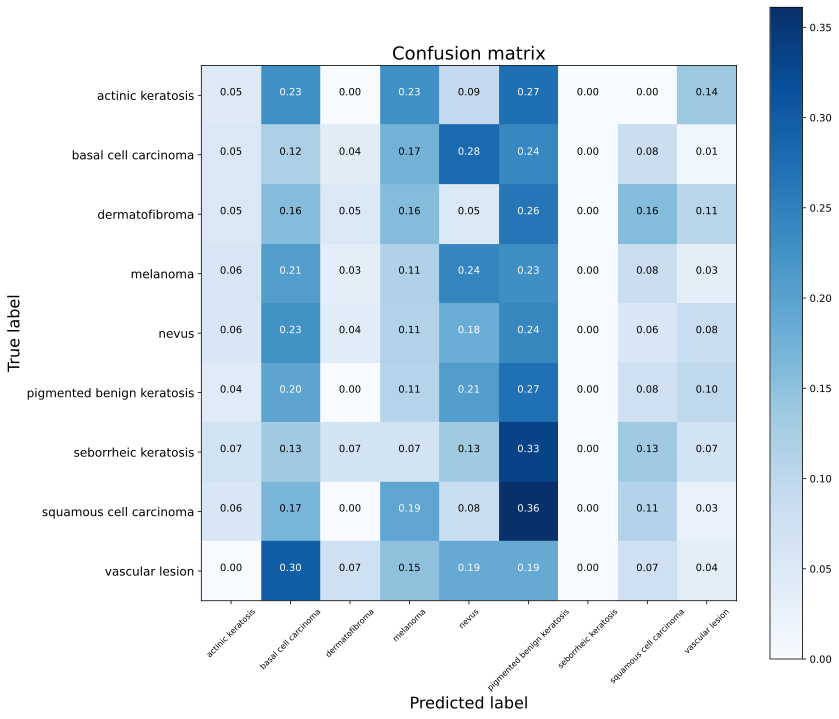

In [128]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [129]:
# классификация ответов

print(classification_report(test_generator.classes, y_pred2, target_names=list(classes.values())))

                            precision    recall  f1-score   support

         actinic keratosis       0.05      0.05      0.05        22
      basal cell carcinoma       0.11      0.12      0.11        75
            dermatofibroma       0.08      0.05      0.06        19
                  melanoma       0.16      0.11      0.14        87
                     nevus       0.15      0.18      0.16        71
pigmented benign keratosis       0.22      0.27      0.24        92
      seborrheic keratosis       0.00      0.00      0.00        15
   squamous cell carcinoma       0.11      0.11      0.11        36
           vascular lesion       0.04      0.04      0.04        27

                  accuracy                           0.14       444
                 macro avg       0.10      0.10      0.10       444
              weighted avg       0.14      0.14      0.14       444



In [ ]:
# Confugn matrix по валидационным данным

In [105]:
%%time
Y_pred1 = model.predict_generator(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

20/20 [==============================] - 10s 538ms/step
CPU times: user 10.3 s, sys: 1.3 s, total: 11.6 s
Wall time: 10.5 s


array([3, 4, 0, 0, 0, 0, 5, 0, 0, 0, 4, 5, 0, 0, 0, 5, 1, 1, 1, 1, 1, 7,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 5, 3, 4, 5, 4, 2, 5, 2, 2, 5,
       5, 1, 2, 7, 4, 5, 4, 4, 5, 3, 8, 5, 4, 5, 5, 3, 3, 4, 4, 5, 3, 4,
       3, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 4, 7, 5, 5, 2, 2, 5, 5, 5,
       5, 5, 5, 5, 1, 7, 5, 1, 3, 3, 3, 4, 1, 3, 5, 3, 1, 7, 7, 1, 7, 1,
       1, 0, 5, 5, 7, 8, 8, 8])

In [106]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


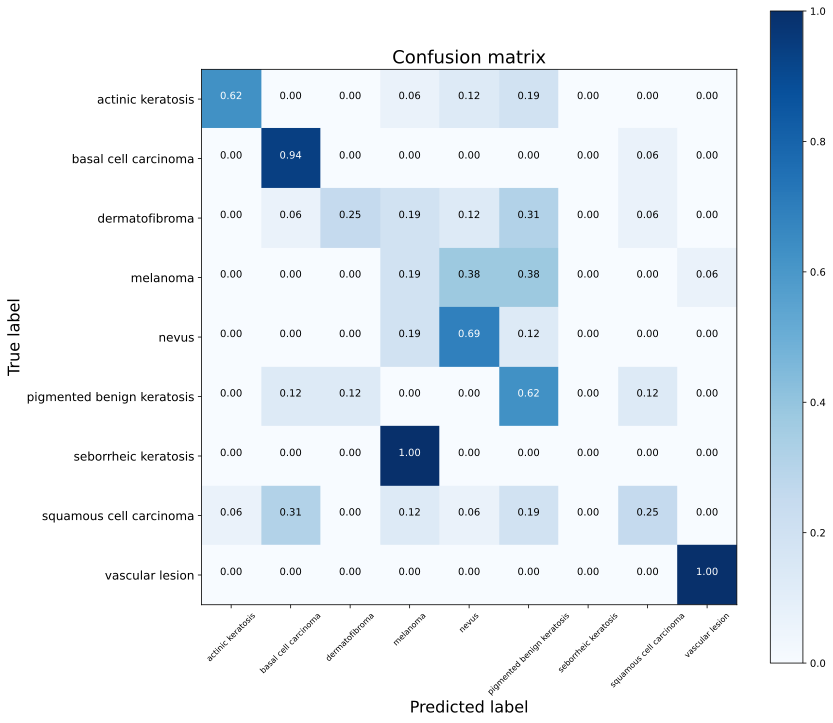

In [107]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [108]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

                            precision    recall  f1-score   support

         actinic keratosis       0.91      0.62      0.74        16
      basal cell carcinoma       0.65      0.94      0.77        16
            dermatofibroma       0.67      0.25      0.36        16
                  melanoma       0.20      0.19      0.19        16
                     nevus       0.50      0.69      0.58        16
pigmented benign keratosis       0.34      0.62      0.44        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.50      0.25      0.33        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.51       118
                 macro avg       0.50      0.51      0.48       118
              weighted avg       0.53      0.51      0.49       118



# Tестовая демонстрация.

In [109]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(image):
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    tta_step = 3
    predictions = []
    for i in range(tta_step):
        preds = model.predict(np.asarray([img]))[0]
        predictions.append(preds)
    pred = np.mean(predictions, axis=0)
    probabilities = pred
#    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

In [110]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


Источник: class: pigmented benign keratosis, file: pigmented benign keratosis/ISIC_0024851.jpg
Предсказано: класс: pigmented benign keratosis, с вероятностью: 0.383679
Предсказано: класс: dermatofibroma, с вероятностью: 0.224924
Предсказано: класс: basal cell carcinoma, с вероятностью: 0.165810


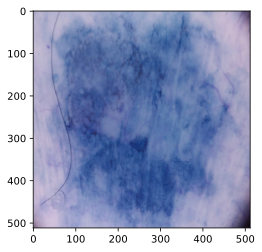

<Figure size 432x288 with 0 Axes>

Источник: class: nevus, file: nevus/ISIC_0000080.jpg
Предсказано: класс: vascular lesion, с вероятностью: 0.779348
Предсказано: класс: basal cell carcinoma, с вероятностью: 0.123587
Предсказано: класс: pigmented benign keratosis, с вероятностью: 0.056648


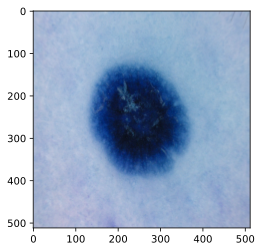

Источник: class: vascular lesion, file: vascular lesion/ISIC_0025628.jpg
Предсказано: класс: vascular lesion, с вероятностью: 1.000000
Предсказано: класс: actinic keratosis, с вероятностью: 0.000000
Предсказано: класс: basal cell carcinoma, с вероятностью: 0.000000


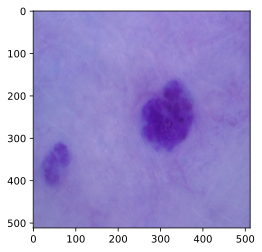

<Figure size 432x288 with 0 Axes>

In [120]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][0]], prediction[1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][1]], prediction[1][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[prediction[0][2]], prediction[1][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()